## Grid building tests.

### 2D grid, center coord. pairs.

In [ ]:
from shared.preface import *
import shared.functions as fct

def grid_2D(l, s):

    # 2D spatial grid, discretized.
    eps = s/10
    x, y = np.mgrid[-l:l+eps:s, -l:l+eps:s]

    # [x y] edge coordinate pairs of above grid.
    xy = np.mgrid[-l:l+eps:s, -l:l+eps:s].reshape(2,-1).T

    # Create center coord.-pairs.
    x_centers = (x[1:,:] + x[:-1,:])/2.
    y_centers = (y[:,1:] + y[:,:-1])/2.
    centers = np.array([x_centers[:,:-1], y_centers[:-1,:]])
    cent_coordPairs2D = centers.reshape(2,-1).T
    print('All coord. pairs 2D:\n', cent_coordPairs2D)
    # print('Coord pairs 2D shape:', cent_coordPairs2D.shape)

    return cent_coordPairs2D

limit_coarse, space_coarse = 1.5, 1.
cent_coordPairs2D = grid_2D(limit_coarse, space_coarse)

# Delete middle square.
cent_coordPairs2D = np.delete(cent_coordPairs2D, 4, axis=0)

# Create finegrained square.
limit_fine, space_fine = limit_coarse/2., space_coarse/2.
cent_coordPairs2D_fine = grid_2D(limit_fine, space_fine)

# Insert finegrained square.

### 3D grid, center coord. pairs.

In [ ]:
from shared.preface import *
import shared.functions as fct

# 3D spatial grid, discretized.
x, y, z = np.mgrid[-1:1.1:1., -1:1.1:1., -1:1.1:1.]
# print(x[0,...], x.shape)

x_centers = (x[1:,...] + x[:-1,...])/2.
# print(x_centers, x_centers.shape)

y_centers = (y[:,1:,:] + y[:,:-1,:])/2.
# print(y_centers, y_centers.shape)

z_centers = (z[...,1:] + z[...,:-1])/2.
# print(z_centers, z_centers.shape)


# Create center coord.-pairs., truncate redundant points.
centers3D = np.array([
    x_centers[:,:-1,:-1], 
    y_centers[:-1,:,:-1], 
    z_centers[:-1,:-1,:]
])
# print(centers3D, centers3D.shape)

cent_coordPairs3D = centers3D.reshape(3,-1).T 
print(cent_coordPairs3D, cent_coordPairs3D.shape)

In [ ]:
from shared.preface import *
import shared.functions as fct

grid = fct.grid_3D(200,100)


fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

xg, yg, zg = grid[:,0], grid[:,1], grid[:,2] 
ax.scatter(xg, yg, zg, s=0.2, marker='x', color='black', alpha=0.5)
ax.view_init(-170,90)

## Analyze gravity.

In [ ]:
from shared.preface import *
import shared.functions as fct

### -------------------------------- ###
### Initialize parameters and files. ###
### -------------------------------- ###

# Parameters.
sim_id = 'L006N188'
snap_num = '0036'
z = 0

# Generate progenitor index list.
# note on init_halo for L006N188 sim: 0 is ~1e12Msun, 1 & 2 are ~1e11Msun.
m0, prog_idx = fct.read_MergerTree(init_halo=0) 
halo_0036 = prog_idx[0][0]

# Generate file for DM particles of chosen halo and get parameters.
halo_cNFW, halo_rvir, halo_Mvir = fct.read_DM_positions(
    which_halos='halos', mass_select=12,  # outdated but necessary...
    random=False, snap_num=snap_num, sim=sim_id, 
    halo_index=int(halo_0036), init_m=m0, save_params=True
)
halo_rvir *= kpc
halo_Mvir = 10**halo_Mvir * Msun
halo_rho0 = fct.scale_density_NFW(z, halo_cNFW)
halo_Rs = halo_rvir / halo_cNFW
print(
    f'Halo parameters: (m0={m0})',
    '\n', 
    f'halo_index={halo_0036} ; cNFW={halo_cNFW:.2f}',
    f'rvir={halo_rvir/kpc:.2f} kpc ; Mvir={halo_Mvir/Msun:.2e} Msun'
)

DM_raw = np.load(
    f'CubeSpace/DM_positions_{sim_id}_snapshot_{snap_num}_{m0}Msun.npy'
)*kpc
DM_pos = np.expand_dims(DM_raw, axis=0)

DM_lim_custom = 1000000

# Custom initial grid.
GRID_L_custom = 300*kpc
GRID_S_custom = 300*kpc

adapted_cc, cell_gen, cell_com, DM_count = fct.manual_cell_division(
    sim_id, snap_num, DM_raw,
    DM_lim_custom, GRID_L_custom, GRID_S_custom
)

### ------------------------------- ###
### Calculate gravity of cell grid. ###
### ------------------------------- ###
long_yesno = True
adapted_DM = np.repeat(DM_pos, len(adapted_cc), axis=0)
fct.cell_gravity_3D(
    adapted_cc, cell_com, cell_gen,
    adapted_DM, DM_count, DM_SIM_MASS, snap_num,
    long_range=long_yesno, test_names=True
)
dPsi_grid = np.load(f'CubeSpace/dPsi_grid_snapshot_TestFile.npy')
cube_mags = np.sqrt(np.sum(dPsi_grid**2, axis=1))


### ------------------------------------------- ###
### Calculate NFW gravity with halo parameters. ###
### ------------------------------------------- ###
adapted_grid = np.squeeze(adapted_cc, axis=1)
NFW_grav = np.array([
    fct.dPsi_dxi_NFW(x_i, z, halo_rho0, halo_Mvir, halo_rvir, halo_Rs, 'MW')
    for x_i in adapted_grid
])
NFW_mags = np.sqrt(np.sum(NFW_grav**2, axis=1))

# Sort cells by distance from center (0,0,0).
grid_dis = np.sqrt(np.sum(adapted_grid**2, axis=1))
dis_ind = grid_dis.argsort()

grid_dis = grid_dis[dis_ind]
cube_mags = cube_mags[dis_ind]
NFW_mags = NFW_mags[dis_ind]

In [ ]:
fig, ax = plt.subplots(1,1)

diff = (NFW_mags-cube_mags)/NFW_mags

ax.scatter(
    grid_dis/kpc, diff, s=5, alpha=0.8, label=f'{m0} Msun halo'
)
ax.axhline(1, c='red', ls=':')
ax.axhline(0, c='green', ls=':')


# def y_fmt_here(value, tick_number):
#     return np.round(1-value,1)
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt_here))

thumb_rule ='(<0 stronger, 0 as strong, 1 much weaker)'
ax.set_title(
    f'Sim is {thumb_rule} than NFW'
    '\n'
    'Multiple dots for each x-axis point, since multiple cells share same distance'
    )
ax.set_xlabel(f'Cell distance from center (kpc)')
ax.set_ylabel(f'gravity ratio')
ax.set_ylim(-100,10)
plt.legend(loc='lower right')
plt.savefig('figures/sim_vs_NFW_gravity.pdf')
plt.show()

## Visualize LSS: (sub)halos and cell division.

Halo parameters: 
 cNFW=8.61 rvir=260.50 kpc ; Mvir=1.89e+12 1.89e+12 Msun
Grid and DM shapes before division: (8, 1, 3) (8, 1375226, 3)
cell division rounds: 6
Shapes of output files: (526, 1, 3) (526,) (526, 3) (526,)
Total DM count across all cells: 1369611
Cells with 0 DM in them: 9 / 526


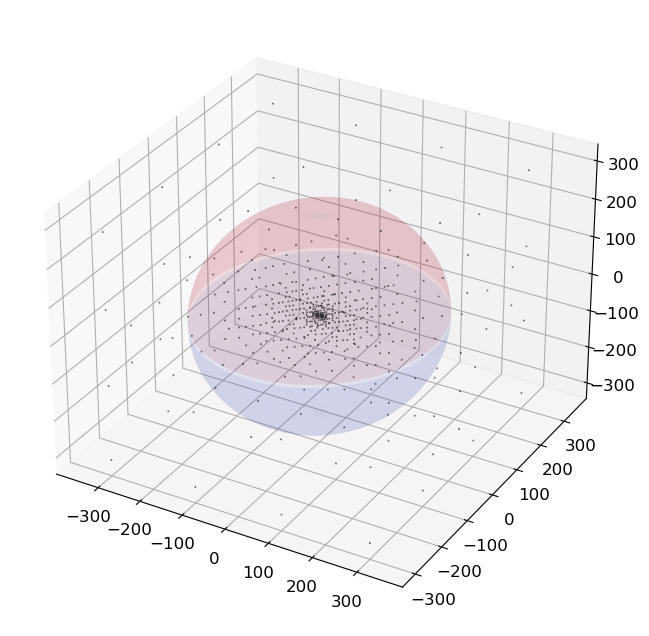

In [7]:
from shared.preface import *
import shared.functions as fct

# %matplotlib widget

# Parameters.
sim_id = 'L006N188'
snap_num = '0036'
z = 0
halo_type = 'halos'
mass_gauge = 11


if halo_type == 'halos':
    # Generate progenitor index list.
    # note on init_halo for L006N188 sim: 0 is ~1e12Msun, 1 & 2 are ~1e11Msun.
    init_halo = 0
    m0, prog_idx = fct.read_MergerTree(init_halo) 

    # Generate file for DM particles of chosen halo and get parameters.
    halo_cNFW, halo_rvir, halo_Mvir = fct.read_DM_positions(
        random=False, snap_num=snap_num, sim=sim_id, 
        halo_index=int(init_halo), init_m=m0, save_params=True
    )
    halo_rvir *= kpc
    halo_Mvir = 10**halo_Mvir * Msun

    DM_raw = np.load(
        f'CubeSpace/DM_positions_{sim_id}_snapshot_{snap_num}_{m0}Msun.npy'
    )*kpc

elif halo_type == 'subhalos':
    # Generate file for DM particles of chosen halo and get parameters.
    halo_cNFW, halo_rvir, halo_Mvir = fct.read_DM_positions(
        which_halos=halo_type, mass_select=mass_gauge, mass_range=1,
        random=True, snap_num=snap_num, sim=sim_id, 
        save_params=True
    )
    halo_rvir *= kpc
    halo_Mvir = 10**halo_Mvir * Msun

    DM_raw = np.load(
        f'CubeSpace/DM_positions_{halo_type}_M{mass_gauge}.npy'
    )*kpc

print(
    f'Halo parameters:',
    '\n', 
    f'cNFW={halo_cNFW:.2f}',
    f'rvir={halo_rvir/kpc:.2f} kpc ; Mvir={halo_Mvir/Msun:.2e} {m0} Msun'
)

DM_lim_custom = 10000
GRID_L_custom = 400*kpc
GRID_S_custom = 400*kpc

adapted_cc, cell_gen, cell_com, DM_count = fct.manual_cell_division(
    sim_id, snap_num, DM_raw,
    DM_lim_custom, GRID_L_custom, GRID_S_custom
)


################################################
### Plotting the outcome after iteration(s). ###
################################################

# Build grid around Milky Way.
# trimmed_cc = np.delete(adapted_cc, np.s_[DM_count==0], axis=0)
# print(trimmed_cc.shape)
new_grid = np.squeeze(adapted_cc, axis=1) / kpc

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Plot DM.
# DM_raw /= kpc
# x_DM, y_DM, z_DM = DM_raw[:,0], DM_raw[:,1], DM_raw[:,2]
# cut = 10
# x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]
# ax.scatter(x, y, z, alpha=0.9, c='rebeccapurple', s=0.001)

# Draw sphere around GC with radius=Rvir_MW.
rGC = halo_rvir/kpc
uGC, vGC = np.mgrid[0:2 * np.pi:200j, 0:np.pi:100j]
xGC = rGC * np.cos(uGC) * np.sin(vGC)
yGC = rGC * np.sin(uGC) * np.sin(vGC)
zGC = rGC * np.cos(vGC)

# Plot Grid.
xg, yg, zg = new_grid[:,0], new_grid[:,1], new_grid[:,2] 
ax.scatter(xg, yg, zg, s=0.2, marker='x', color='black', alpha=0.5)

# Can't make it show up with all the DM particles.
# ax.scatter(
#     X_SUN[0], X_SUN[1], X_SUN[2], s=10, color='blue', marker='o',
#     label='Earth', zorder=0
# )

ax.plot_surface(
    xGC, yGC, zGC, alpha=0.1, 
    cmap=plt.cm.coolwarm, vmin=-1, vmax=1,# antialiased=False,
    rstride=1, cstride=1
)

# ax.view_init(-170,90)

zero_cells = np.count_nonzero(DM_count==0.)
print(f'Cells with 0 DM in them: {zero_cells} / {len(new_grid)}')

plt.savefig('figures/cell_division_fix.pdf')
plt.show()

## Visualize halo mass evolution through snapshots.

In [ ]:
sim_ID = 'L006N188'

# Path to merger_tree file (has to have been generated with merger_tree.py)
tree_path = f'{pathlib.Path.cwd().parent}/neutrino_clustering_output_local/MergerTree/MergerTree_{sim_ID}.hdf5'

with h5py.File(tree_path) as tree:
    choice = 1  #note: 0 is ~1e12Msun, 1 & 2 are ~1e11Msun
    Masses = tree['Assembly_history/Mass'][choice,:]
    zeds = tree['Assembly_history/Redshift']
    
    y = np.asarray(Masses)
    x = np.asarray(zeds)

    fig = plt.figure()
    plt.semilogy(x, y, label=f'{y[0]:.2e}')
    plt.title(u'Starting mass in labels ->')
    plt.xlabel('redshift')
    plt.ylabel('halo masses [Msun]')
    plt.legend()
    plt.show()

## Neutrino velocity batches.

In [ ]:
from shared.preface import *
import shared.functions as fct

nus = 10000
MW_HALO = True
VC_HALO = False
AG_HALO = False
halos = 'MW'*MW_HALO + '+VC'*VC_HALO + '+AG'*AG_HALO

fig, ax = plt.subplots(1,2)
for j, method in enumerate(('smooth', 'discrete')):

    if method == 'smooth':
        Cubes = False
    else:
        Cubes = True

    # Load positions and velocities.
    vel = fct.load_u_sim(nus, halos=halos, discrete=Cubes)
    pos = fct.load_x_sim(nus, halos=halos, discrete=Cubes)

    # Magnitudes of velocities and radial distances from halo center.
    mag = np.sqrt(np.sum(vel**2, axis=2))
    dis = np.sqrt(np.sum(pos**2, axis=2))

    # Sort arrays from low to high velocity neutrinos.
    ids = mag[:,0].argsort()
    ids_2D = np.repeat(np.expand_dims(ids, axis=1), mag.shape[1], axis=1)
    u_unit = (kpc/s)/(km/s)
    mag_sort = np.take_along_axis(mag, ids_2D, axis=0)*u_unit
    dis_sort = np.take_along_axis(dis, ids_2D, axis=0)

    # Special velocity markers.
    v_start = mag_sort[:,0]
    v_max = v_start.max()
    v_esc = mag_sort[np.where(v_start <= 550)]

    # Velocity batches.
    v1 = mag_sort[np.where(v_start <= v_max/4)]
    v2 = mag_sort[
        np.where((v_max/4 < v_start) & (v_start <= v_max/2))
    ]
    v3 = mag_sort[
        np.where((v_max/2 < v_start) & (v_start <= v_max*3/4))
    ]
    v4 = mag_sort[np.where(v_max*3/4 < v_start)]
    print('vel patches:', v1.shape, v2.shape, v3.shape, v4.shape)

    print(
        'Velocity edges for each batch: \n', 
        f'Batch 1: {v1[0,0]} to {v1[-1,0]} check: {v_max/4} \n',
        f'Batch 2: {v2[0,0]} to {v2[-1,0]} check: {v_max/2} \n',
        f'Batch 3: {v3[0,0]} to {v3[-1,0]} check: {v_max*3/4} \n',
        f'Batch 3: {v4[0,0]} to {v4[-1,0]} check: {v_max}',
    )

    # Corresponding distance batches.
    d1 = dis_sort[:len(v1),:]
    d2 = dis_sort[len(v1):len(v1)+len(v2),:]
    d3 = dis_sort[len(v1)+len(v2):len(v1)+len(v2)+len(v3),:]
    d4 = dis_sort[len(v1)+len(v2)+len(v3):,:]
    print('dis patches:', d1.shape, d2.shape, d3.shape, d4.shape)
    # d_esc = dis_sort[:v_esc.shape[0],:]

    batches = False

    if batches == True:
        for i, d in enumerate((d1,d2,d3,d4)):
            print(d.shape, d[0,0], d[0,-1])
            y_vals = np.mean(d, axis=0)
            ax[j].semilogy(ZEDS, y_vals, alpha=0.7, label=f'batch {i} mean')
    else:
        d_low = dis_sort[:3000,:][::300]  #! lowest velocities
        for d in d_low:
            ax[j].semilogy(ZEDS, d)

    ax[j].axhline(Rvir_MW/kpc, c='r', ls=':', label='MW R_vir')
    # ax[j].set_xlim(-0.01,1)
    ax[j].legend()
    ax[j].set_title(f'{method} simulation')
    ax[j].set_xlabel('redshift')

    if j == 0:
        ax[j].set_ylabel('distance to halo center (kpc)')

plt.savefig('figures/velocity_batches.pdf')
plt.show()